In [1]:
import numpy as np
import pandas as pd
import joblib
from scipy import linalg
import dask.dataframe as dd
import xgboost as xgb

In [2]:
usecols_indices = list(range(3, 26))
data = dd.read_csv('附件2/M201.csv').compute()
new_data = dd.read_csv("附件2/M201.csv",usecols=usecols_indices).compute()

In [3]:
def process_predictions(predictions):
    t = []  # 初始化空列表，用于存储事件信息
    time_temp = 0  # 初始化持续时间计数器
    flag = 1  # 初始化标志，用于标记新事件的开始
    for i in range(predictions.size):
        if predictions[i] < 0.6:
            if time_temp != 0:
                # 记录事件的开始日期、开始时间和持续时间
                t.append({'日期': day, '开始时间': temp, '持续时间': time_temp})
                time_temp = 0  # 重置持续时间计数器
                flag = 1  # 重置标志，标记新事件的开始
        else:
            time_temp += 1  # 增加持续时间计数器
            if flag == 1:
                day = data.iloc[i][0]  # 记录新事件的开始日期
                temp = data.iloc[i][1]  # 记录新事件的开始时间
                flag = 0  # 标记新事件已开始

    # 循环结束后，如果time_temp不为0，表示最后一个事件未结束，需要记录
    if time_temp != 0:
        t.append({'日期': day, '开始时间': temp, '持续时间': time_temp})

    return t

In [4]:
def process_predictions_gnb_tree(predictions):
    t = []  # 初始化空列表，用于存储事件信息
    time_temp = 0  # 初始化持续时间计数器
    flag = 1  # 初始化标志，用于标记新事件的开始
    for i in range(predictions.size):
        if predictions[i] == 0:
            if time_temp != 0:
                # 记录事件的开始日期、开始时间和持续时间
                t.append({'日期': day, '开始时间': temp, '持续时间': time_temp})
                time_temp = 0  # 重置持续时间计数器
                flag = 1  # 重置标志，标记新事件的开始
        else:
            time_temp += 1  # 增加持续时间计数器
            if flag == 1:
                day = data.iloc[i][0]  # 记录新事件的开始日期
                temp = data.iloc[i][1]  # 记录新事件的开始时间
                flag = 0  # 标记新事件已开始

    # 循环结束后，如果time_temp不为0，表示最后一个事件未结束，需要记录
    if time_temp != 0:
        t.append({'日期': day, '开始时间': temp, '持续时间': time_temp})

    return t

In [5]:
def count_events_per_month(time):
    month = np.zeros(13)  # 初始化12个月份的计数器
    x, y = time.shape  # 获取数据框的行数和列数
    
    for i in range(x):
        month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引
        month[month_index] += 1  # 对应月份的事件数量加1
        
    return month

In [6]:
loaded_model_1001_bst = joblib.load('M101的1001故障模型_bst.pkl')
loaded_model_1001_gnb = joblib.load('M101的1001故障模型_gnb.pkl')
loaded_model_1001_tree = joblib.load('M101的1001故障模型_tree.pkl')

In [7]:
data_1001_bst = xgb.DMatrix(new_data)
predictions_1001_bst = loaded_model_1001_bst.predict(data_1001_bst)

predictions_1001_gnb = loaded_model_1001_gnb.predict(new_data)

predictions_1001_tree = loaded_model_1001_tree.predict(new_data)

In [8]:
time_1001_bst = pd.DataFrame(process_predictions(predictions_1001_bst))
time_1001_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_1001_gnb))
time_1001_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_1001_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\765400564.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\765400564.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [9]:
month_1001_bst = count_events_per_month(time_1001_bst)
month_1001_gnb = count_events_per_month(time_1001_gnb)
month_1001_tree = count_events_per_month(time_1001_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


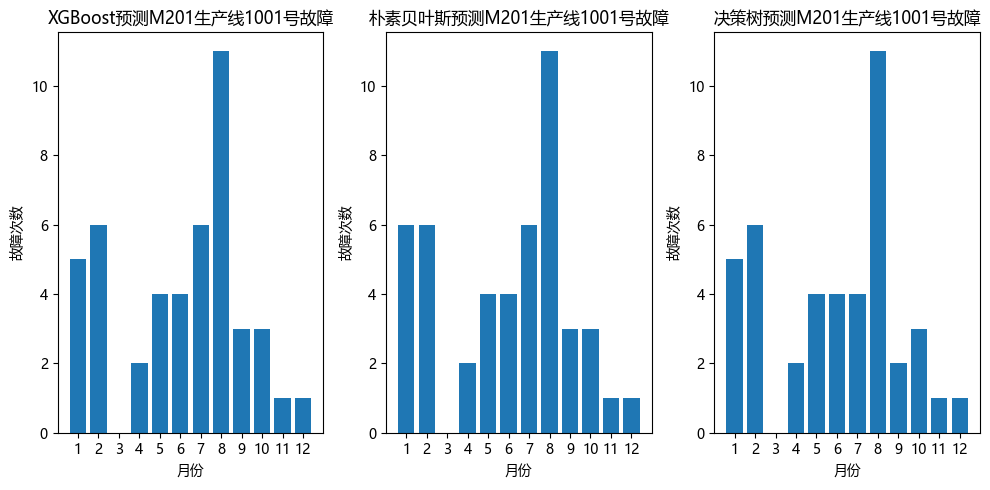

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_1001_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线1001号故障")

axs[1].bar(list(range(1,13)),month_1001_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线1001号故障")

axs[2].bar(list(range(1,13)),month_1001_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线1001号故障")

plt.tight_layout()
plt.show()

In [11]:
loaded_model_2001_bst = joblib.load('M101的2001故障模型_bst.pkl')
loaded_model_2001_gnb = joblib.load('M101的2001故障模型_gnb.pkl')
loaded_model_2001_tree = joblib.load('M101的2001故障模型_tree.pkl')

In [12]:
data_2001_bst = xgb.DMatrix(new_data)
predictions_2001_bst = loaded_model_2001_bst.predict(data_2001_bst)

predictions_2001_gnb = loaded_model_2001_gnb.predict(new_data)

predictions_2001_tree = loaded_model_2001_tree.predict(new_data)

In [13]:
time_2001_bst = pd.DataFrame(process_predictions(predictions_2001_bst))
time_2001_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_2001_gnb))
time_2001_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_2001_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\765400564.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\765400564.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [14]:
month_2001_bst = count_events_per_month(time_2001_bst)
month_2001_gnb = count_events_per_month(time_2001_gnb)
month_2001_tree = count_events_per_month(time_2001_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


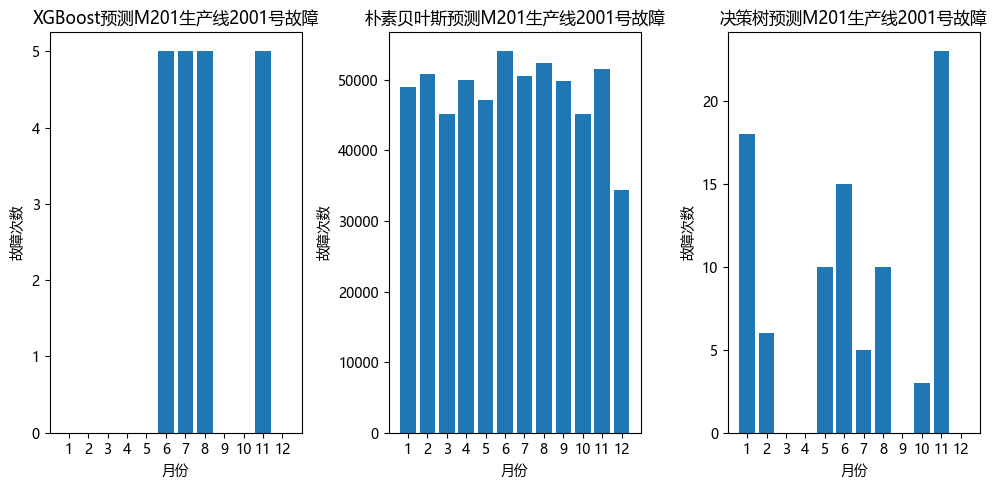

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_2001_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线2001号故障")

axs[1].bar(list(range(1,13)),month_2001_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线2001号故障")

axs[2].bar(list(range(1,13)),month_2001_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线2001号故障")

plt.tight_layout()
plt.show()

In [16]:
loaded_model_4001_bst = joblib.load('M101的4001故障模型_bst.pkl')
loaded_model_4001_gnb = joblib.load('M101的4001故障模型_gnb.pkl')
loaded_model_4001_tree = joblib.load('M101的4001故障模型_tree.pkl')

In [17]:
data_4001_bst = xgb.DMatrix(new_data)
predictions_4001_bst = loaded_model_4001_bst.predict(data_4001_bst)

predictions_4001_gnb = loaded_model_4001_gnb.predict(new_data)

predictions_4001_tree = loaded_model_4001_tree.predict(new_data)

In [18]:
time_4001_bst = pd.DataFrame(process_predictions(predictions_4001_bst))
time_4001_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_4001_gnb))
time_4001_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_4001_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [19]:
month_4001_bst = count_events_per_month(time_4001_bst)
month_4001_gnb = count_events_per_month(time_4001_gnb)
month_4001_tree = count_events_per_month(time_4001_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


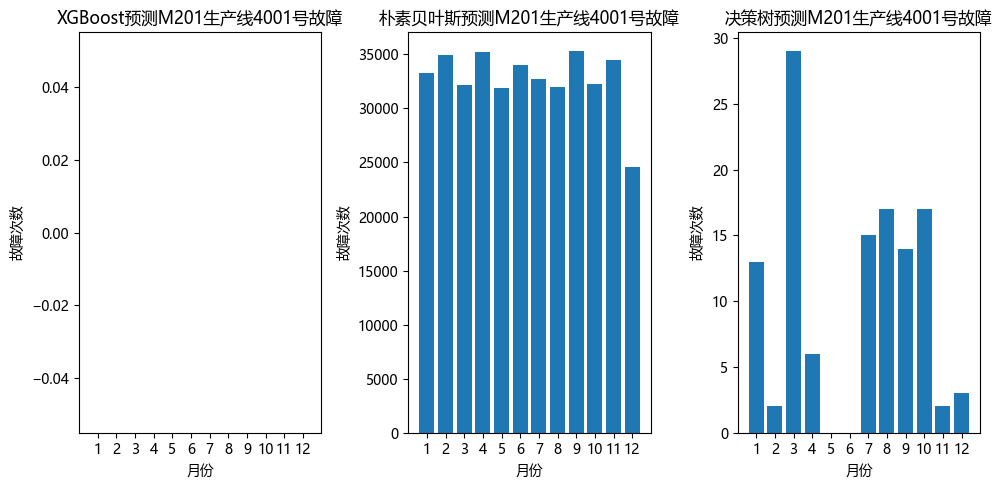

In [20]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_4001_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线4001号故障")

axs[1].bar(list(range(1,13)),month_4001_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线4001号故障")

axs[2].bar(list(range(1,13)),month_4001_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线4001号故障")

plt.tight_layout()
plt.show()

In [21]:
loaded_model_4002_bst = joblib.load('M101的4002故障模型_bst.pkl')
loaded_model_4002_gnb = joblib.load('M101的4002故障模型_gnb.pkl')
loaded_model_4002_tree = joblib.load('M101的4002故障模型_tree.pkl')

In [22]:
data_4002_bst = xgb.DMatrix(new_data)
predictions_4002_bst = loaded_model_4002_bst.predict(data_4002_bst)

predictions_4002_gnb = loaded_model_4002_gnb.predict(new_data)

predictions_4002_tree = loaded_model_4002_tree.predict(new_data)

In [23]:
time_4002_bst = pd.DataFrame(process_predictions(predictions_4002_bst))
time_4002_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_4002_gnb))
time_4002_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_4002_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\765400564.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\765400564.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [24]:
month_4002_bst = count_events_per_month(time_4002_bst)
month_4002_gnb = count_events_per_month(time_4002_gnb)
month_4002_tree = count_events_per_month(time_4002_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


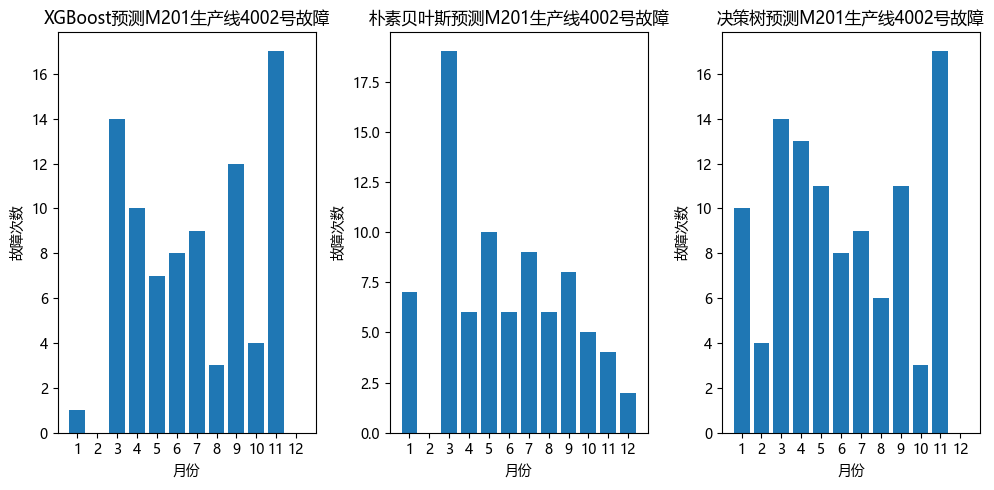

In [25]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_4002_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线4002号故障")

axs[1].bar(list(range(1,13)),month_4002_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线4002号故障")

axs[2].bar(list(range(1,13)),month_4002_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线4002号故障")

plt.tight_layout()
plt.show()

In [26]:
loaded_model_4003_bst = joblib.load('M101的4003故障模型_bst.pkl')
loaded_model_4003_gnb = joblib.load('M101的4003故障模型_gnb.pkl')
loaded_model_4003_tree = joblib.load('M101的4003故障模型_tree.pkl')

In [27]:
data_4003_bst = xgb.DMatrix(new_data)
predictions_4003_bst = loaded_model_4003_bst.predict(data_4003_bst)

predictions_4003_gnb = loaded_model_4003_gnb.predict(new_data)

predictions_4003_tree = loaded_model_4003_tree.predict(new_data)

In [28]:
time_4003_bst = pd.DataFrame(process_predictions(predictions_4003_bst))
time_4003_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_4003_gnb))
time_4003_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_4003_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [29]:
month_4003_bst = count_events_per_month(time_4003_bst)
month_4003_gnb = count_events_per_month(time_4003_gnb)
month_4003_tree = count_events_per_month(time_4003_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


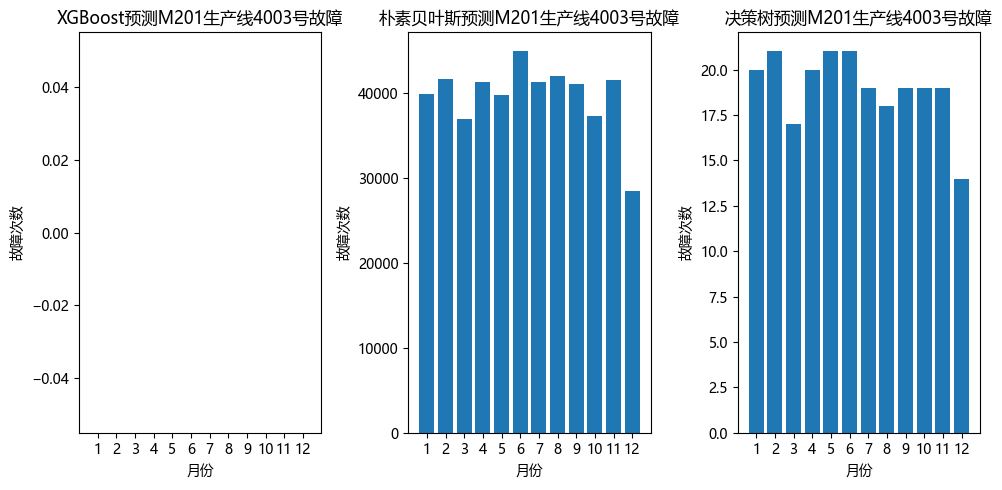

In [30]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_4003_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线4003号故障")

axs[1].bar(list(range(1,13)),month_4003_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线4003号故障")

axs[2].bar(list(range(1,13)),month_4003_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线4003号故障")

plt.tight_layout()
plt.show()

In [31]:
loaded_model_5001_bst = joblib.load('M101的5001故障模型_bst.pkl')
loaded_model_5001_gnb = joblib.load('M101的5001故障模型_gnb.pkl')
loaded_model_5001_tree = joblib.load('M101的5001故障模型_tree.pkl')

In [32]:
data_5001_bst = xgb.DMatrix(new_data)
predictions_5001_bst = loaded_model_5001_bst.predict(data_5001_bst)

predictions_5001_gnb = loaded_model_5001_gnb.predict(new_data)

predictions_5001_tree = loaded_model_5001_tree.predict(new_data)

In [33]:
time_5001_bst = pd.DataFrame(process_predictions(predictions_5001_bst))
time_5001_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_5001_gnb))
time_5001_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_5001_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [34]:
month_5001_bst = count_events_per_month(time_5001_bst)
month_5001_gnb = count_events_per_month(time_5001_gnb)
month_5001_tree = count_events_per_month(time_5001_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


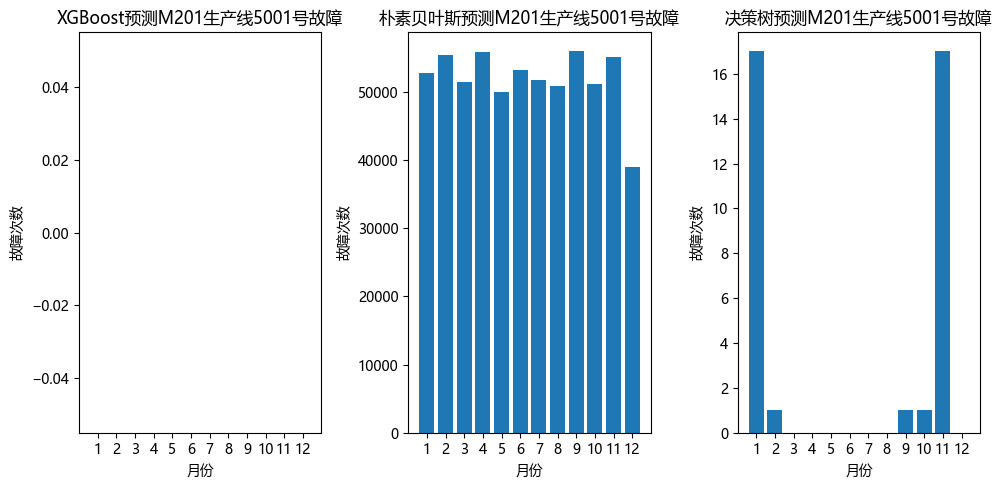

In [35]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_5001_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线5001号故障")

axs[1].bar(list(range(1,13)),month_5001_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线5001号故障")

axs[2].bar(list(range(1,13)),month_5001_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线5001号故障")

plt.tight_layout()
plt.show()

In [36]:
loaded_model_5002_bst = joblib.load('M101的5002故障模型_bst.pkl')
loaded_model_5002_gnb = joblib.load('M101的5002故障模型_gnb.pkl')
loaded_model_5002_tree = joblib.load('M101的5002故障模型_tree.pkl')

In [37]:
data_5002_bst = xgb.DMatrix(new_data)
predictions_5002_bst = loaded_model_5002_bst.predict(data_5002_bst)

predictions_5002_gnb = loaded_model_5002_gnb.predict(new_data)

predictions_5002_tree = loaded_model_5002_tree.predict(new_data)

In [38]:
time_5002_bst = pd.DataFrame(process_predictions(predictions_5002_bst))
time_5002_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_5002_gnb))
time_5002_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_5002_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [39]:
month_5002_bst = count_events_per_month(time_5002_bst)
month_5002_gnb = count_events_per_month(time_5002_gnb)
month_5002_tree = count_events_per_month(time_5002_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


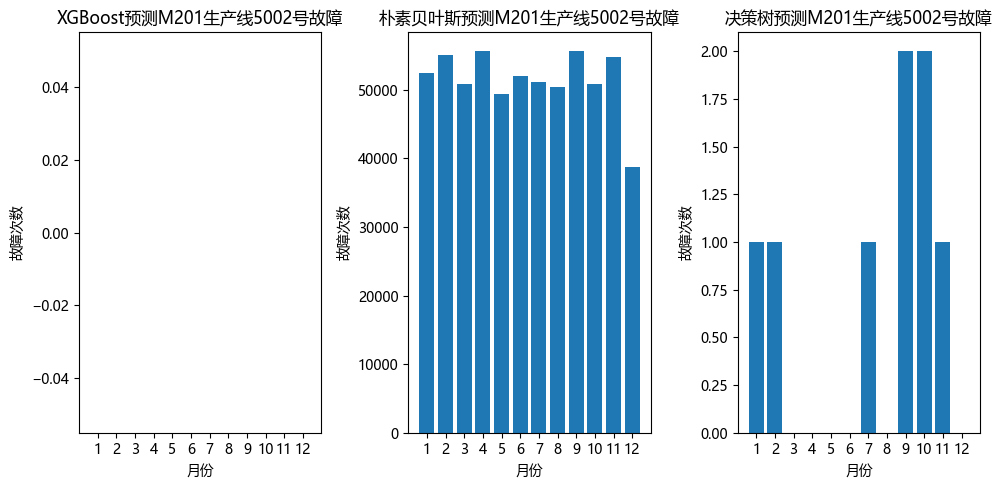

In [40]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_5002_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线5002号故障")

axs[1].bar(list(range(1,13)),month_5002_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线5002号故障")

axs[2].bar(list(range(1,13)),month_5002_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线5002号故障")

plt.tight_layout()
plt.show()

In [41]:
loaded_model_6001_bst = joblib.load('M101的6001故障模型_bst.pkl')
loaded_model_6001_gnb = joblib.load('M101的6001故障模型_gnb.pkl')
loaded_model_6001_tree = joblib.load('M101的6001故障模型_tree.pkl')

In [42]:
data_6001_bst = xgb.DMatrix(new_data)
predictions_6001_bst = loaded_model_6001_bst.predict(data_6001_bst)

predictions_6001_gnb = loaded_model_6001_gnb.predict(new_data)

predictions_6001_tree = loaded_model_6001_tree.predict(new_data)

In [43]:
time_6001_bst = pd.DataFrame(process_predictions(predictions_6001_bst))
time_6001_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_6001_gnb))
time_6001_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_6001_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [44]:
month_6001_bst = count_events_per_month(time_6001_bst)
month_6001_gnb = count_events_per_month(time_6001_gnb)
month_6001_tree = count_events_per_month(time_6001_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


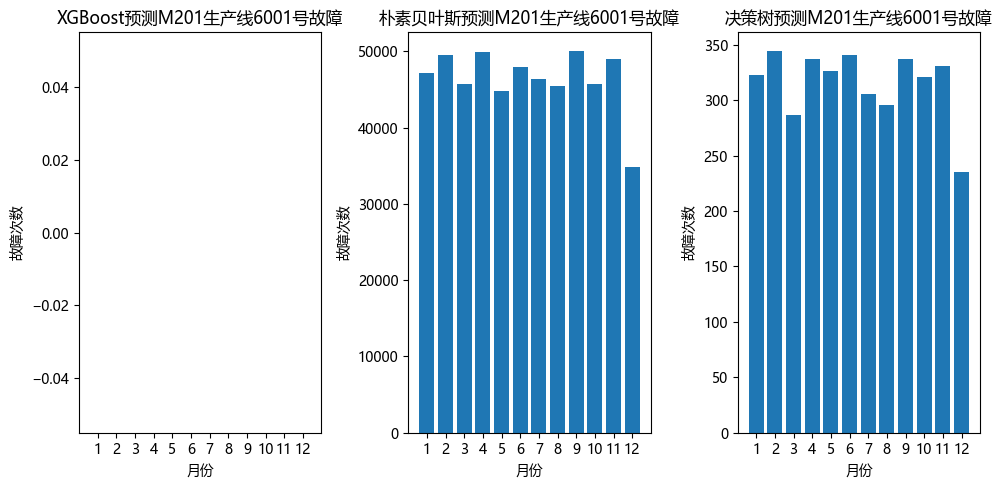

In [45]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_6001_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线6001号故障")

axs[1].bar(list(range(1,13)),month_6001_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线6001号故障")

axs[2].bar(list(range(1,13)),month_6001_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线6001号故障")

plt.tight_layout()
plt.show()

In [63]:
loaded_model_6002_bst = joblib.load('M101的6002故障模型_bst.pkl')
loaded_model_6002_gnb = joblib.load('M101的6002故障模型_gnb.pkl')
loaded_model_6002_tree = joblib.load('M101的6002故障模型_tree.pkl')

In [64]:
data_6002_bst = xgb.DMatrix(new_data)
predictions_6002_bst = loaded_model_6002_bst.predict(data_6002_bst)

predictions_6002_gnb = loaded_model_6002_gnb.predict(new_data)

predictions_6002_tree = loaded_model_6002_tree.predict(new_data)

In [65]:
time_6002_bst = pd.DataFrame(process_predictions(predictions_6002_bst))
time_6002_gnb = pd.DataFrame(process_predictions_gnb_tree(predictions_6002_gnb))
time_6002_tree = pd.DataFrame(process_predictions_gnb_tree(predictions_6002_tree))

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = data.iloc[i][0]  # 记录新事件的开始日期
C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\3948826588.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = data.iloc[i][1]  # 记录新事件的开始时间


In [66]:
month_6002_bst = count_events_per_month(time_6002_bst)
month_6002_gnb = count_events_per_month(time_6002_gnb)
month_6002_tree = count_events_per_month(time_6002_tree)

C:\Users\Raspberry\AppData\Local\Temp\ipykernel_12452\1451421267.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  month_index = int(time.iloc[i][0] / 31) + 1  # 计算月份索引


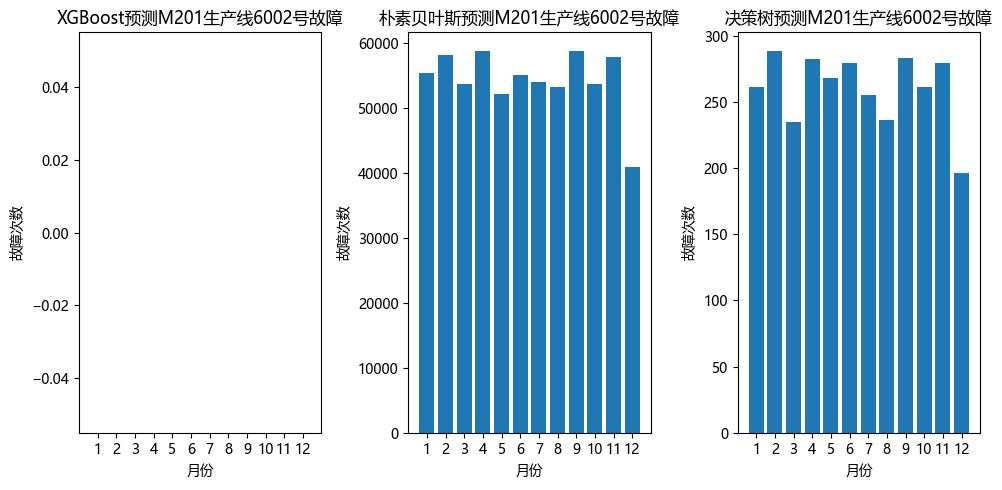

In [67]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']=['Microsoft Yahei']
fig , axs = plt.subplots(1,3,figsize=(10,5))
axs[0].bar(list(range(1,13)),month_6002_bst[1::])
axs[0].set_xticks(range(1,13))
axs[0].set_xlabel("月份")
axs[0].set_ylabel("故障次数")
axs[0].set_title("XGBoost预测M201生产线6002号故障")

axs[1].bar(list(range(1,13)),month_6002_gnb[1::])
axs[1].set_xticks(range(1,13))
axs[1].set_xlabel("月份")
axs[1].set_ylabel("故障次数")
axs[1].set_title("朴素贝叶斯预测M201生产线6002号故障")

axs[2].bar(list(range(1,13)),month_6002_tree[1::])
axs[2].set_xticks(range(1,13))
axs[2].set_xlabel("月份")
axs[2].set_ylabel("故障次数")
axs[2].set_title("决策树预测M201生产线6002号故障")

plt.tight_layout()
plt.show()